In [2]:
import gdown
import os

os.makedirs('data', exist_ok=True)

files = [
    {'name': 'Similarity_Matrix_Proteins.txt', 'url': 'https://drive.google.com/uc?id=1gquLYKwL3zYOAn7sF7chk0TdO8hqcFEo'},
    {'name': 'Similarity_Matrix_Drugs.txt', 'url': 'https://drive.google.com/uc?id=19jxq3-49d10iEfnni9EvESUQrwt9L34I'},
    {'name': 'protein.txt', 'url': 'https://drive.google.com/uc?id=1WDa6RnU0phkCnQfT1NMRjlQcZwRQXWZe'},
    {'name': 'mat_protein_protein.txt', 'url': 'https://drive.google.com/uc?id=1jMueorza0r2e9KBVxdgYpHyzMaHrn2WM'},
    {'name': 'mat_protein_disease.txt', 'url': 'https://drive.google.com/uc?id=1LZplFAT_maRrtzMTmmput2nArRb7EJ-k'},
    {'name': 'mat_drug_se.txt', 'url': 'https://drive.google.com/uc?id=1G5afdkP2xiyizjOVhliFfgg_v0TdJskF'},
    {'name': 'mat_drug_protein.txt', 'url': 'https://drive.google.com/uc?id=1_-O7h8cIJpC0UCAeAIvN6ApN_-aGLBNA'},
    {'name': 'mat_drug_drug.txt', 'url': 'https://drive.google.com/uc?id=1JIVEARFJyOE0k9DXi5hwfSJaChZVzq_t'},
    {'name': 'mat_drug_disease.txt', 'url': 'https://drive.google.com/uc?id=1gC_U-3BuJcR1pV8mqKMz_7y0uRX6wCAG'},
    {'name': 'drug.txt', 'url': 'https://drive.google.com/uc?id=1DEnV7RqGhn3mTk-7fCLUvj-_tkQ_3d8t'},
    {'name': 'mat_drug_protein_remove_homo.txt', 'url': 'https://drive.google.com/uc?id=1i0lYhFSrpUrnNyXoplyBDULcePoVsAK-'},
    {'name': 'se.txt', 'url': 'https://drive.google.com/uc?id=1ExPcXnkypA90HwE5vXJJPzOhLEKAgLeI'},
    {'name': 'disease.txt', 'url': 'https://drive.google.com/uc?id=19v_Zccb4tdXPlondvcIItbEdDXXpdIgd'}
]

for file in files:
    output = f"data/{file['name']}"
    gdown.download(file['url'], output, quiet=False)

print("All files downloaded.")

Downloading...
From: https://drive.google.com/uc?id=1gquLYKwL3zYOAn7sF7chk0TdO8hqcFEo
To: /content/data/Similarity_Matrix_Proteins.txt
100%|██████████| 22.7M/22.7M [00:00<00:00, 78.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jxq3-49d10iEfnni9EvESUQrwt9L34I
To: /content/data/Similarity_Matrix_Drugs.txt
100%|██████████| 8.84M/8.84M [00:00<00:00, 41.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WDa6RnU0phkCnQfT1NMRjlQcZwRQXWZe
To: /content/data/protein.txt
100%|██████████| 10.6k/10.6k [00:00<00:00, 28.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jMueorza0r2e9KBVxdgYpHyzMaHrn2WM
To: /content/data/mat_protein_protein.txt
100%|██████████| 4.57M/4.57M [00:00<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LZplFAT_maRrtzMTmmput2nArRb7EJ-k
To: /content/data/mat_protein_disease.txt
100%|██████████| 16.9M/16.9M [00:00<00:00, 170MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G5afdkP2xiyizjOVhliFfgg_v0TdJskF
To: /conten

All files downloaded.


#Generating Drug and Protein Feature Vectors Using Jaccard Similarity and Random Walk with Restart (RWR)

In [3]:
import numpy as np
import os

# ----------- 1. Jaccard Similarity ------------------
def jaccard_similarity(adj_matrix):
    n = adj_matrix.shape[0]
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        Ai = adj_matrix[i]
        for j in range(i, n):
            Aj = adj_matrix[j]
            union = np.logical_or(Ai, Aj).sum()
            if union == 0:
                sim = 0
            else:
                sim = np.logical_and(Ai, Aj).sum() / union
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
    return sim_matrix

# ----------- 2. Random Walk with Restart (RWR) ------------------
def normalize_matrix(A):
    row_sums = A.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-12
    return A / row_sums

def rwr(A, restart_prob=0.5, max_iter=20, tol=1e-6):
    B = normalize_matrix(A)
    n = B.shape[0]
    diffusion_states = np.zeros((n, n))
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        s = e.copy()
        for _ in range(max_iter):
            s_new = (1 - restart_prob) * np.dot(s, B) + restart_prob * e
            if np.linalg.norm(s_new - s, 1) < tol:
                break
            s = s_new
        diffusion_states[i] = s
    return diffusion_states

# ----------- 3. Input file mapping ------------------
drug_files = {
    "drug_drug": "mat_drug_drug.txt",
    "drug_disease": "mat_drug_disease.txt",
    "drug_se": "mat_drug_se.txt",
    "drug_sim": "Similarity_Matrix_Drugs.txt"  # similarity matrix: skip Jaccard
}

protein_files = {
    "protein_protein": "mat_protein_protein.txt",
    "protein_disease": "mat_protein_disease.txt",
    "protein_sim": "Similarity_Matrix_Proteins.txt"  # similarity matrix: skip Jaccard
}

# ----------- 4. Apply Jaccard and RWR on a single file ------------------
def process_file(path, use_jaccard=True):
    mat = np.loadtxt(path)
    sim = jaccard_similarity(mat) if use_jaccard else mat
    return rwr(sim)

# ----------- 5. Process drug features ------------------
drug_feature_list = []
for name, filename in drug_files.items():
    print(f"Processing {name} ...")
    path = os.path.join("data", filename)
    use_jaccard = not filename.startswith("Similarity")
    diffused = process_file(path, use_jaccard)
    drug_feature_list.append(diffused)

# ----------- 6. Process protein features ------------------
protein_feature_list = []
for name, filename in protein_files.items():
    print(f"Processing {name} ...")
    path = os.path.join("data", filename)
    use_jaccard = not filename.startswith("Similarity")
    diffused = process_file(path, use_jaccard)
    protein_feature_list.append(diffused)

# ----------- 7. Merge all feature matrices ------------------
drug_feature_matrix = np.concatenate(drug_feature_list, axis=1)     # (708, 2832)
protein_feature_matrix = np.concatenate(protein_feature_list, axis=1)  # (1512, 4536)

print("✅ Drug features shape:", drug_feature_matrix.shape)
print("✅ Protein features shape:", protein_feature_matrix.shape)

# ----------- 8. Save output matrices ------------------
np.save("drug_features.npy", drug_feature_matrix)
np.save("protein_features.npy", protein_feature_matrix)


Processing drug_drug ...
Processing drug_disease ...
Processing drug_se ...
Processing drug_sim ...
Processing protein_protein ...
Processing protein_disease ...
Processing protein_sim ...
✅ Drug features shape: (708, 2832)
✅ Protein features shape: (1512, 4536)


#Variational Autoencoder (VAE) for Dimensionality Reduction of Drug and Protein Features

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import MinMaxScaler

# --------------------- 1. Load raw features ---------------------
X_drug = np.load("drug_features.npy")
X_protein = np.load("protein_features.npy")

# --------------------- 2. Normalize ---------------------
X_drug_norm = MinMaxScaler().fit_transform(X_drug)
X_protein_norm = MinMaxScaler().fit_transform(X_protein)

# --------------------- 3. Add noise function ---------------------
def add_noise(x, noise_factor=0.2):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return tf.clip_by_value(x_noisy, 0.0, 1.0)

# --------------------- 4. Define Improved VAE ---------------------
class ImprovedVAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = models.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(1024, activation='softplus'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(512, activation='softplus'),
            layers.BatchNormalization()
        ])
        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

        # Decoder
        self.decoder = models.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(512, activation='softplus'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(1024, activation='softplus'),
            layers.Dense(input_dim, activation='linear')
        ])

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")

    def encode(self, x):
        h = self.encoder(x)
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z, z_mean, z_log_var

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        z, _, _ = self.encode(x)
        return self.decode(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        noisy_data = add_noise(data)

        with tf.GradientTape() as tape:
            z, z_mean, z_log_var = self.encode(noisy_data)
            reconstruction = self.decode(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

latent_dim_drug = 100
vae_drug = ImprovedVAE(input_dim=X_drug.shape[1], latent_dim=latent_dim_drug)
vae_drug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
vae_drug.fit(X_drug_norm, epochs=50, batch_size=16, verbose=1)

z_drug, _, _ = vae_drug.encode(X_drug_norm)
np.save("X_drug_encoded.npy", z_drug.numpy())
print("✅ Drug encoding saved:", z_drug.shape)

latent_dim_protein = 400
vae_protein = ImprovedVAE(input_dim=X_protein.shape[1], latent_dim=latent_dim_protein)
vae_protein.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
vae_protein.fit(X_protein_norm, epochs=50, batch_size=32, verbose=1)

z_protein, _, _ = vae_protein.encode(X_protein_norm)
np.save("X_protein_encoded.npy", z_protein.numpy())
print("✅ Protein encoding saved:", z_protein.shape)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 18.5262
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 16/50
45/45

#Denoising Autoencoder (DAE) for Compressing Drug and Protein Features Extracted via RWR

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.preprocessing import MinMaxScaler

# ----------- 1. Load raw drug and protein features extracted via RWR -----------
X_drug = np.load("drug_features.npy")       # (708, 2832)
X_protein = np.load("protein_features.npy") # (1512, 4536)

# ----------- 2. Normalize the feature matrices -----------
scaler_drug = MinMaxScaler()
X_drug_norm = scaler_drug.fit_transform(X_drug)

scaler_protein = MinMaxScaler()
X_protein_norm = scaler_protein.fit_transform(X_protein)

# ----------- 3. Define Denoising Autoencoder architecture -----------
def build_dae(input_dim, hidden_dim):
    input_layer = layers.Input(shape=(input_dim,))
    noisy_input = layers.GaussianNoise(0.2)(input_layer)
    encoded = layers.Dense(hidden_dim, activation='softplus')(noisy_input)
    decoded = layers.Dense(input_dim, activation='linear')(encoded)
    dae = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=encoded)
    dae.compile(optimizer=optimizers.RMSprop(), loss=losses.MeanSquaredError())
    return dae, encoder

# ----------- 4. Train DAE on drug features -----------
dae_drug, encoder_drug = build_dae(X_drug.shape[1], 100)
dae_drug.fit(X_drug_norm, X_drug_norm,
             epochs=30,
             batch_size=16,
             shuffle=True,
             validation_split=0.1,
             verbose=1)

X_drug_encoded = encoder_drug.predict(X_drug_norm)
print("✅ Encoded Drug Features Shape:", X_drug_encoded.shape)

# ----------- 5. Train DAE on protein features -----------
dae_protein, encoder_protein = build_dae(X_protein.shape[1], 400)
dae_protein.fit(X_protein_norm, X_protein_norm,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

X_protein_encoded = encoder_protein.predict(X_protein_norm)
print("✅ Encoded Protein Features Shape:", X_protein_encoded.shape)

# ----------- 6. Save encoded representations -----------
np.save("X_drug_encoded_DAE.npy", X_drug_encoded)  # (708, 100)
np.save("X_protein_encoded_DAE.npy", X_protein_encoded) # (1512, 400)



Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0135 - val_loss: 0.0015
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_l

#Comparison of VAE and DAE for Drug–Target Interaction Prediction Using DTI-CNN


🔷 VAE Evaluation:
VAE 🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
VAE 🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
VAE 🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
VAE 🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
VAE 🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
VAE 🔁 Fold 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
VAE 🔁 Fold 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
VAE 🔁 Fold 8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
VAE 🔁 Fold 9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
VAE 🔁 Fold 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

🟠 DAE Evaluation:
DAE 🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DAE 🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
DAE 🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
DAE 🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
DAE 🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
DAE 🔁 Fold 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DAE 🔁 Fold 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
DAE 🔁 Fold 8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
DAE 🔁 Fold 9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
DAE 🔁 Fold 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


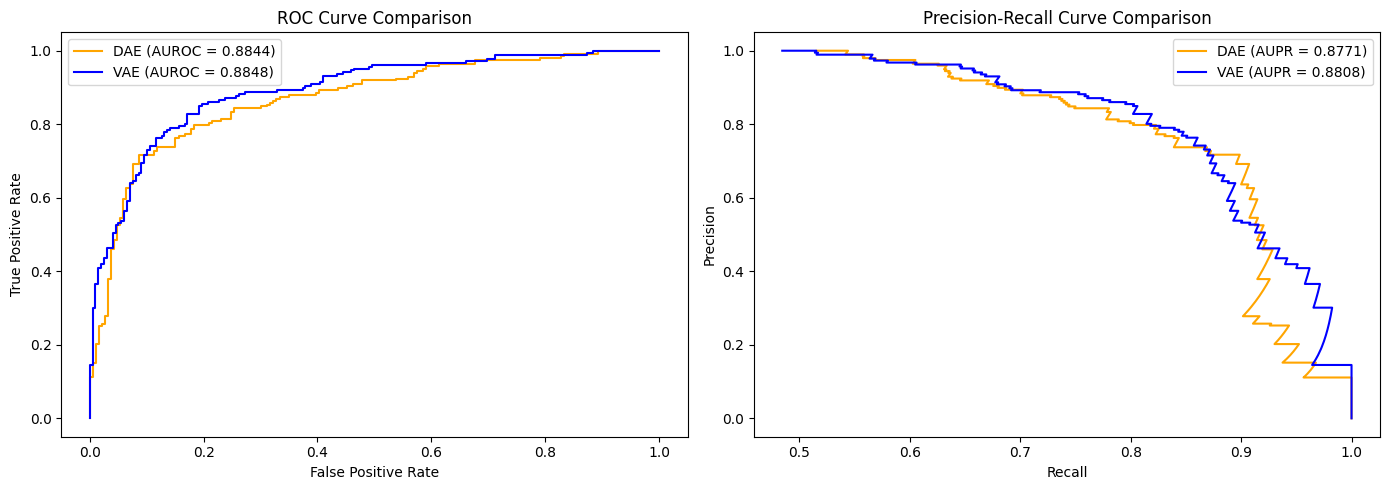


✅ DAE - AUROC: 0.8844 | AUPR: 0.8771
✅ VAE - AUROC: 0.8848 | AUPR: 0.8808


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def build_dataset(X_drug, X_protein, mat_dp, negative_ratio=1.0):
    pos_pairs = np.argwhere(mat_dp == 1)
    num_pos = pos_pairs.shape[0]
    num_neg = int(num_pos * negative_ratio)
    neg_candidates = np.argwhere(mat_dp == 0)
    np.random.shuffle(neg_candidates)
    neg_pairs = neg_candidates[:num_neg]

    all_pairs = np.concatenate([pos_pairs, neg_pairs])
    labels = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_pairs))])

    idx = np.arange(len(labels))
    np.random.shuffle(idx)

    all_pairs = all_pairs[idx]
    labels = labels[idx]

    X = np.array([
        np.concatenate([X_drug[i], X_protein[j]]) for i, j in all_pairs
    ])
    return X, labels

def build_cnn(input_dim=500):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(filters=16, kernel_size=4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(180, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def train_and_evaluate(X_drug, X_protein, mat_dp, label="Model"):
    X, y = build_dataset(X_drug, X_protein, mat_dp, negative_ratio=1.0)
    kf = KFold(n_splits=10)

    auroc_scores = []
    aupr_scores = []
    roc_data = None
    pr_data = None

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"{label} 🔁 Fold {fold + 1}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = build_cnn(input_dim=X.shape[1])
        model.fit(X_train, y_train, epochs=35, batch_size=64, verbose=0)

        y_pred = model.predict(X_test).flatten()

        auroc = roc_auc_score(y_test, y_pred)
        aupr = average_precision_score(y_test, y_pred)
        auroc_scores.append(auroc)
        aupr_scores.append(aupr)

        if fold == 9:
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            rec, prec, _ = precision_recall_curve(y_test, y_pred)
            roc_data = (fpr, tpr)
            pr_data = (rec, prec)

    return {
        "auroc_mean": np.mean(auroc_scores),
        "aupr_mean": np.mean(aupr_scores),
        "roc_data": roc_data,
        "pr_data": pr_data
    }

# ------------------ Load all features ------------------
X_drug_vae = np.load("X_drug_encoded.npy")
X_prot_vae = np.load("X_protein_encoded.npy")
X_drug_dae = np.load("X_drug_encoded_DAE.npy")
X_prot_dae = np.load("X_protein_encoded_DAE.npy")
mat_dp = np.loadtxt("data/mat_drug_protein.txt")

# ------------------ Train and Evaluate both ------------------
print("\n🔷 VAE Evaluation:")
vae_result = train_and_evaluate(X_drug_vae, X_prot_vae, mat_dp, label="VAE")

print("\n🟠 DAE Evaluation:")
dae_result = train_and_evaluate(X_drug_dae, X_prot_dae, mat_dp, label="DAE")

# ------------------ Plotting ------------------
plt.figure(figsize=(14, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(dae_result["roc_data"][0], dae_result["roc_data"][1], label=f"DAE (AUROC = {dae_result['auroc_mean']:.4f})", color='orange')
plt.plot(vae_result["roc_data"][0], vae_result["roc_data"][1], label=f"VAE (AUROC = {vae_result['auroc_mean']:.4f})", color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

# PR
plt.subplot(1, 2, 2)
plt.plot(dae_result["pr_data"][0], dae_result["pr_data"][1], label=f"DAE (AUPR = {dae_result['aupr_mean']:.4f})", color='orange')
plt.plot(vae_result["pr_data"][0], vae_result["pr_data"][1], label=f"VAE (AUPR = {vae_result['aupr_mean']:.4f})", color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# ------------------ Summary Print ------------------
print(f"\n✅ DAE - AUROC: {dae_result['auroc_mean']:.4f} | AUPR: {dae_result['aupr_mean']:.4f}")
print(f"✅ VAE - AUROC: {vae_result['auroc_mean']:.4f} | AUPR: {vae_result['aupr_mean']:.4f}")
